## Implement Quasiparticle Hamiltonian on a IonQ simulator

In [1]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict


Load matrix elements for $^{18}O$

In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]

print(t_onebody)


{(0, 0): -6.2321, (0, 1): 1.0430999999999995, (0, 2): -3.763858685577873, (1, 0): 1.0430999999999995, (1, 1): -6.2321, (1, 2): 3.763858685577873, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -2.9203}


#### Build-up $H_Q$

In [3]:
def get_hamiltonian(t_onebody:Dict, n_sites:int):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.25*t_val) )
            YY_tuples.append(("YY", [i, j], 0.25*t_val) )
            
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples], num_qubits=n_sites)
    return hamiltonian.simplify()



Get the manybody basis

In [4]:
import numpy as np
from qiskit.quantum_info import Statevector

n_sites=n_qubits
basis_states = [Statevector.from_label(np.binary_repr(i, width=n_sites)) for i in range(2**n_sites)]

bitstring_to_index = {np.binary_repr(i, width=n_sites): i for i in range(2**n_sites)}
index_to_bitstring = {i: np.binary_repr(i, width=n_sites) for i in range(2**n_sites)}

In [38]:
print(index_to_bitstring)

{0: '000', 1: '001', 2: '010', 3: '011', 4: '100', 5: '101', 6: '110', 7: '111'}


In [5]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits)




#### Qiskit has the sick problem that the occupation value 1 becomes 0 (they define $S_z$ in the opposite way). Therefore, to select the Hamiltonian fixed in the one quasiparticle many-body basis we need to consider the conversion to the full bitstrig basis 

bitstring_index= 63- $2^{sp \; index}$

In [6]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_q.to_matrix())[2**(i-1),2**(j-1)]} \n')
        
### We got exactly the same Hamiltonian!

i=0,j=0 ->(-6.232099999999999+0j) 

i=0,j=1 ->(1.0430999999999995+0j) 

i=0,j=2 ->(-3.763858685577873+0j) 

i=1,j=0 ->(1.0430999999999995+0j) 

i=1,j=1 ->(-6.232099999999999+0j) 

i=1,j=2 ->(3.763858685577873+0j) 

i=2,j=0 ->(-3.763858685577873+0j) 

i=2,j=1 ->(3.763858685577873+0j) 

i=2,j=2 ->(-2.9202999999999992+0j) 



#### Build-up the driver Hamiltonian

In [7]:
coupling_term=-6.232099999999999
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_sites)


print(hamiltonian_driver)

SparsePauliOp(['IIZ', 'III'],
              coeffs=[ 3.11605+0.j, -3.11605+0.j])


In [8]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_driver.to_matrix())[2**(i-1),2**(j-1)]} \n')
        

i=0,j=0 ->(-6.232099999999999+0j) 

i=0,j=1 ->0j 

i=0,j=2 ->0j 

i=1,j=0 ->0j 

i=1,j=1 ->0j 

i=1,j=2 ->0j 

i=2,j=0 ->0j 

i=2,j=1 ->0j 

i=2,j=2 ->0j 



#### Define the Parameter Hamiltonian $H(s)=s H_Q + (1-s) H_D$

In [9]:
from qiskit.circuit import Parameter

s = Parameter("s")

hamiltonian_s = s * hamiltonian_q + (1 - s) * hamiltonian_driver



In [10]:
dt=0.1
hamiltonian_eval = hamiltonian_s.assign_parameters({s: dt})


In [11]:
from qiskit.quantum_info import  commutator


# Define the total particle number operator N
z_op = [("Z", [i], -0.5) for i in range(n_sites)]
identity=[("I", [i], 0.5) for i in range(n_sites)]
n_operator=SparsePauliOp.from_sparse_list([*z_op,], num_qubits=n_sites)

# Compute the commutator [H, N]
commutator_result = commutator(hamiltonian_eval, n_operator).simplify()

print(commutator_result)

SparsePauliOp(['III'],
              coeffs=[0j])


#### Let's perform the SUZUKI-TROTTER

In [12]:
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector
second_order_formula = SuzukiTrotter(order=1)  # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(hamiltonian_eval, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(hamiltonian_eval.num_qubits)
circuit.append(trotter_step_second_order, range(hamiltonian_eval.num_qubits))
#circuit = circuit.decompose(reps=2)
circuit_opt=circuit
#circuit_opt = transpile(circuit, optimization_level=1)

#final_state=Statevector(circuit_opt)

initial_state=QuantumCircuit(hamiltonian_eval.num_qubits)
initial_state.x([0])

print(Statevector(initial_state).data)

initial_state.append(circuit_opt,circuit_opt.qubits)
final_state=Statevector(initial_state)

[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [26]:
#### full time evolution

In [13]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.transpiler import CouplingMap



In [14]:

#final_state=Statevector(circuit_opt)
time_steps=30
tf=3
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
b=0.8
h=1-(1+b)*(time/tf)+b*(time/tf)**2
initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
initial_state.x([0])

for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    initial_state.append(exp_H_t,range(hamiltonian_q.num_qubits))
    

initial_state=transpile(initial_state, optimization_level=3)
final_state=Statevector(initial_state)

In [15]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {initial_state.depth()}
             Gate count: {len(initial_state)}
    Nonlocal gate count: {initial_state.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in initial_state.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 204
             Gate count: 262
    Nonlocal gate count: 174
         Gate breakdown: RXX: 87, RYY: 87, RZ: 87, U3: 1




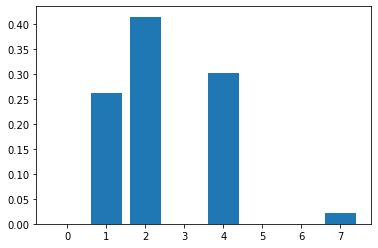

(8,)
(8,)
(8,)


In [16]:
import matplotlib.pyplot as plt



prob=final_state.probabilities()

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

# convert into the single particle state
single_particle_vector=np.zeros(2**n_sites,dtype=np.complex128)

for a in range(n_sites):
    a_mb=2**(a)
    print(final_state.data.shape)
    single_particle_vector[a_mb]=final_state.data[a_mb]
single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
final_state_clean_single_particle=Statevector(single_particle_vector)

In [17]:
print(np.linalg.norm(single_particle_vector))
print(np.linalg.norm(final_state.data))
print(final_state.expectation_value(hamiltonian_q))

1.0
1.0000000000000002
(-10.689717650714119+0j)


#### Ionq simulator

In [ ]:
import os
from qiskit_ionq import IonQProvider


provider = IonQProvider(token="iNarGLptgimgFldYpwMY5x8mTxRZE1C2")
print(provider.backends())

simulator_backend = provider.get_backend("simulator")
simulator_backend.set_options(noise_model="aria-1")

# Create a basic Bell State circuit:


result = simulator_backend.run(initial_state).result()

# Print the counts


#### IBM Noise Model

In [103]:

#final_state=Statevector(circuit_opt)
time_steps=20
tf=2
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
b=1.5
h=1-(1+b)*(time/tf)+b*(time/tf)**2
#h=1-time/tf
initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
initial_state.x([0])

for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    initial_state.append(exp_H_t,range(hamiltonian_q.num_qubits))
    
#ionq_basis = ['rx', 'ry', 'rz', 'cx', 'measure']
initial_state=transpile(initial_state, optimization_level=3)
final_state=Statevector(initial_state)

##### Kind of IBM

In [74]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import (
    depolarizing_error,
    thermal_relaxation_error,
    ReadoutError
)

noise_model = NoiseModel()

# Parameters for decoherence
t1 = 80e3  # ns
t2 = 60e3  # ns
gate_time_1q = 50  # ns
gate_time_2q = 200  # ns

# 1-qubit gate error
error_1q = depolarizing_error(0.001, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time_1q)
)
noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3'])

# 2-qubit gate error
error_2q = depolarizing_error(0.02, 2).compose(
    thermal_relaxation_error(t1, t2, gate_time_2q).tensor(
        thermal_relaxation_error(t1, t2, gate_time_2q))
)
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

# Readout error (asymmetric)
readout_error = ReadoutError([[0.98, 0.02], [0.08, 0.92]])
noise_model.add_all_qubit_readout_error(readout_error)

##### Kind of IonQ

In [104]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate, HGate, CXGate

# System parameters (choose Aria 1 here)
r1q = 0.00004     # 1-qubit error rate
r2q = 0.00139     # 2-qubit error rate best performance ever

# Create noise model
noise_model = NoiseModel()

# Define one-qubit depolarizing error
one_qubit_error = depolarizing_error(r1q, 1)

# Define two-qubit depolarizing error
two_qubit_error = depolarizing_error(r2q, 2)

# # Add the one-qubit error to all single-qubit gates


# # Add the two-qubit error to all two-qubit gates (like CX)

    
    
# Assume 0.001 single-qubit error, 0.01 two-qubit error
one_q_error = depolarizing_error(r1q, 1)
two_q_error = depolarizing_error(r2q, 2)

# Add to your favorite gates
#noise_model.add_all_qubit_quantum_error(one_q_error, ['u3'])
#noise_model.add_all_qubit_quantum_error(two_q_error, ['cx'])
for gate in ['cx', 'cz', 'swap']:
    noise_model.add_all_qubit_quantum_error(two_qubit_error, gate)
for gate in ['id', 'x', 'y', 'z', 'h', 's', 't', 'rx', 'ry', 'rz', 'u1', 'u2', 'u3']:
    noise_model.add_all_qubit_quantum_error(one_qubit_error, gate)

In [105]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix

sim = AerSimulator(noise_model=noise_model)
initial_state.save_density_matrix()
# Transpile and run
tqc = transpile(initial_state, sim,optimization_level=3)
result = sim.run(tqc).result()



In [ ]:
tqc.draw()

In [106]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {tqc.depth()}
             Gate count: {len(tqc)}
    Nonlocal gate count: {tqc.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in tqc.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 381
             Gate count: 460
    Nonlocal gate count: 228
         Gate breakdown: CX: 228, RZ: 114, U2: 61, U3: 54, H: 2, SAVE_DENSITY_MATRIX: 1




In [107]:
# Get the output state vector or density matrix
from qiskit.quantum_info import DensityMatrix,state_fidelity
dm = result.data(0)['density_matrix']
print(dm.shape)
density_matrix_final_state=DensityMatrix(dm)
print(density_matrix_final_state.expectation_value(hamiltonian_q))

(8, 8)
(-8.752130639419354-1.9887930541126508e-16j)


/tmp/ipykernel_3641130/3824665734.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print(dm.shape)


/tmp/ipykernel_3641130/4149363579.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]
/tmp/ipykernel_3641130/4149363579.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]


<BarContainer object of 8 artists>

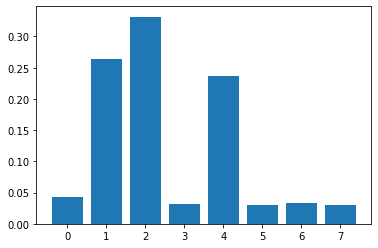

In [108]:
sp_dm=np.zeros((2**n_qubits,2**n_qubits))
for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]

sp_dm=sp_dm/np.trace(sp_dm)
density_matrix_final_state_single_particle=DensityMatrix(sp_dm)

plt.bar(np.arange(2**n_qubits),density_matrix_final_state.probabilities())

(-8.76545923291306+0j) 0.5716095325001441


<BarContainer object of 8 artists>

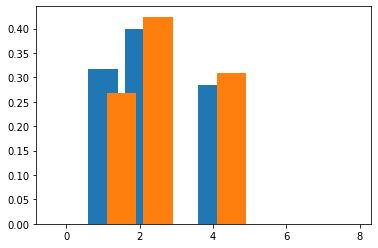

In [109]:
print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q),state_fidelity(density_matrix_final_state,final_state_clean_single_particle))

plt.bar(np.arange(2**n_qubits),density_matrix_final_state_single_particle.probabilities())
plt.bar(np.arange(2**n_qubits)+0.5,final_state_clean_single_particle.probabilities())


#### Writing down the Hamiltonian using RXX, RYY and RZ (an alternative that can be not considered here in qiskit)

In [68]:
def exp_hamiltonian_q(qc,t_onebody,time,n_sites):
    for a in range(n_sites):
        for b in range(a,n_sites):
            if a!=b:
                value=time*t_onebody[a,b]
                qc.rxx(value,a,b)
                
            if a==b:
                value=time*t_onebody[a,b]
                qc.p(value,a)

    for a in range(n_sites):
        for b in range(a,n_sites):
            if a!=b:
                value=time*t_onebody[a,b]
                qc.ryy(value,a,b)
                

def exp_hamiltonian_driving(qc,coupling_term,index,time,n_sites):
    value=time*coupling_term
    qc.p(value,index)






In [204]:
from qiskit import QuantumCircuit

# Create a 6-qubit quantum circuit
qc = QuantumCircuit(6)

# Apply an X-gate to the first qubit to set it to |1⟩
qc.x([0])

# At this point, the state is [1, 0, 0, 0, 0, 0] (i.e., |100000⟩) the initial state of the QA protocol

# Optionally, you can print the circuit
print(qc.draw())

tf=10
time=np.linspace(0,tf,100)

for t in time:
    
    exp_hamiltonian_driving(qc,coupling_term=coupling_term,index=0,time=1-t/tf,n_sites=n_sites)
    exp_hamiltonian_q(qc,t_onebody=t_onebody,time=t/tf,n_sites=n_sites)
#qc=qc.decompose(reps=2)    
qc_opt=transpile(qc, optimization_level=3)
    

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
          
q_3: ─────
          
q_4: ─────
          
q_5: ─────
          


In [ ]:
qc.draw('text')

In [206]:
qc.draw()
print(
    f"""
                  Depth: {qc.depth()}
             Gate count: {len(qc)}
    Nonlocal gate count: {qc.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in qc.count_ops().items()])}

"""
)


                  Depth: 1305
             Gate count: 3701
    Nonlocal gate count: 3000
         Gate breakdown: RXX: 1500, RYY: 1500, P: 700, X: 1




In [207]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import numpy as np
shots=1000
sim_statevector = AerSimulator(method='statevector')
job_statevector = sim_statevector.run(qc)
results_statevector = job_statevector.result()#.get_counts(0)

final_state=Statevector(qc)

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


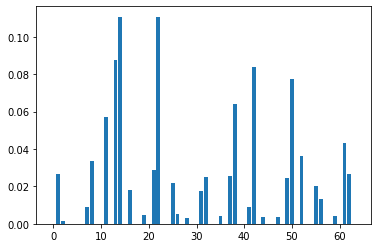

In [208]:
import matplotlib.pyplot as plt
prob=np.conjugate(final_state.data)*final_state.data

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

# convert into the single particle state
single_particle_vector=np.zeros(n_sites,dtype=np.complex128)

for a in range(n_sites):
    a_mb=2**a
    single_particle_vector[a]=final_state.data[a_mb]



In [209]:
print(np.linalg.norm(single_particle_vector))
print(np.linalg.norm(final_state.data))

0.32342941816803605
1.0000000000000078
